In [1]:
def loadFile(filename=''):
    import pickle
    import numpy as np
    if not filename:
        filepath = respath.DEFAULT_DATA_NAME + '20201227.pkl'
    elif len(filename.split('/')) > 1:
        filepath = filename
        fileformat = filename.split('/')[-1].split('.')[1]
    else:
        fileformat = filename.split('.')[1]
        filepath = respath.DEFAULT_DATA_NAME + filename
    try:
        f = open(filepath, 'rb')
        if fileformat == 'pkl':
            return pickle.load(f)
        elif fileformat == 'npy':
            return np.load(f)
        else:
            return errorhandle.UNKNOW_FILE_FORMAT
    except IOError:
        return errorhandle.LOAD_FILE_IO_ERROR

import pandas as pd
import matplotlib.pyplot as plt

def parse2pd(perf):
    caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
    long = max(len(caltime), len(colrtime), len(colgtime))
    if len(caltime) < long:
        perf["calcualte"] = caltime.extend([0]*(long - len(caltime)))
    if len(colrtime) < long:
        perf["col Radar"] = colrtime.extend([0]*(long - len(colrtime)))
    if len(colgtime) < long:
        perf["col GPS"] = colgtime.extend([0]*(long - len(colgtime)))
    pd_perf = pd.DataFrame(perf)
    return pd_perf

import numpy as np
def showPerf(perf):
    assert type(perf) == dict
    for ele in perf:
        print("Length of " + ele + " is " + str(len(perf[ele])))
        print("Max time conso for " + ele + " is " + str(max(perf[ele])))
        print("Mean time conso for " + ele + " is " + str(np.mean(perf[ele])))
#     caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
#     print("Length caltime time, colrtime, colgtime", end = ':')
#     print(len(caltime), end=' | ')
#     print(len(colrtime), end = ' | ')
#     print(len(colgtime))
#     print("Max time: ")
#     print(max(caltime), end='|')
#     print(max(colrtime), end='|')
#     print(max(colgtime))
#     print("Mean time: ")
#     print(np.mean(caltime), end='|')
#     print(np.mean(colrtime), end='|')
#     print(np.mean(colgtime))
#     return caltime, colrtime, colgtime


由于Radar cas性能上的问题，具体表现为：
- 界面卡死，控制台出现 Process finished with exit code -1073741571 (0xC00000FD)的错误。    

查到的信息是StackOverFlow堆栈溢出的错误，有可能是一个类的变量过大导致内存溢出。 不过我觉得不太可能是此原因，有一次为了解决算法对接的错误，需要把416x416窗口的数据保存下来且每5道数据算是一个窗口，于是运行了5000个点之后保存下来，窗口数据达到了2.5G，但程序也没有卡死出错。内存绝对是够的。
我开始怀疑大概还是线程的问题，我给3个独立进行任务的线程设定了启动的频率（雷达收集/GPS收集/计算）：
- 0.05s/0.05s/0.3s：这个频率就是比较理想的，但是到了5000-8000条数据之间程序会卡死。
- 0.08s/0.08s/0.3s： 偏慢一些，程序会在12000-15000条数据之间卡死
- 0.1s/0.1s/0.5s：这个速度，收集雷达数据对比雷达发送的速度就显得得非常慢了，程序大概会在15000-18000之间卡死

也就是说，速度越慢，容错率就越高。所以究竟是什么如此费时间呢，我在程序中的线程插入了时间锁分别计算在模拟数据的情况下，**雷达数据收集，GPS数据收集以及不使用神经网络计算情况下的计算消耗时间**。   

下面这个文件perf3000_20Hz就是在0.05/0.3秒触发一次线程情况下收集3000个点的时间。

In [4]:
perf = loadFile("F:/RadarCAS/data/performance/perf3000_20Hz.pkl")
showPerf(perf)

Length of col Radar is 3040
Max time conso for col Radar is 1.5106364908148748
Mean time conso for col Radar is 0.052005731542433535
Length of col GPS is 3040
Max time conso for col GPS is 0.0010164698229004898
Mean time conso for col GPS is 4.979047644234799e-05
Length of calcualte is 596
Max time conso for calcualte is 0.0031837340734170994
Mean time conso for calcualte is 0.0005442997559853386


可以看到，在模拟情况下，GPS收集的平均速度是最快的， 最慢也不超过0.01秒，而不涉及神经网络的计算也不是很费时间，但雷达这一块平均时间已经超过0.05，最高达到1.51s.这尼玛就没有道理。

<IPython.core.display.Javascript object>


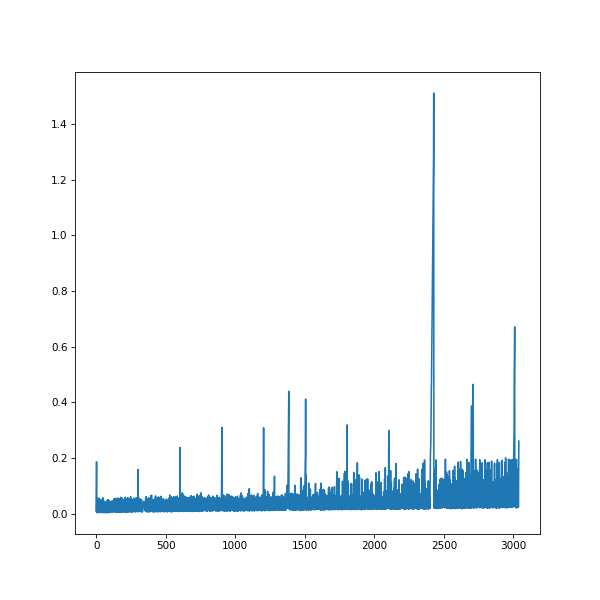

In [5]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
perf["calcualte"].extend([0]*(len(colrtime) - len(caltime)))
a = pd.DataFrame(perf)

plt.figure(figsize=(8,8), dpi=60)
plt.plot(a['col Radar'])
plt.show()

这是雷达收集时间的折线图，可以看到两个特点： 
- 每隔300道数据会有一个时间特别长的点
- 总体来说，随着数据量增加，平均时间变长了

In [6]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_4000_20Hz"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])

showPerf(perf)

Length of col Radar is 4000
Max time conso for col Radar is 1.0862077845023634
Mean time conso for col Radar is 0.03941431611157373
Length of col GPS is 3997
Max time conso for col GPS is 0.00019004220985152642
Mean time conso for col GPS is 3.399192483945655e-05
Length of calcualte is 683
Max time conso for calcualte is 0.0018431986121782984
Mean time conso for calcualte is 0.00033001111316173943


第二次修改了一下代码，由于不知道程序什么时候会爆，设置每1000条数据保存下来， 这次保存了4000条数据。看起来所花时间整体比第一次3000个点要低不少，大概是因为第一次测试收集性能数据的时候，电脑同时在跑着很多程序， CPU100%占用。

<IPython.core.display.Javascript object>


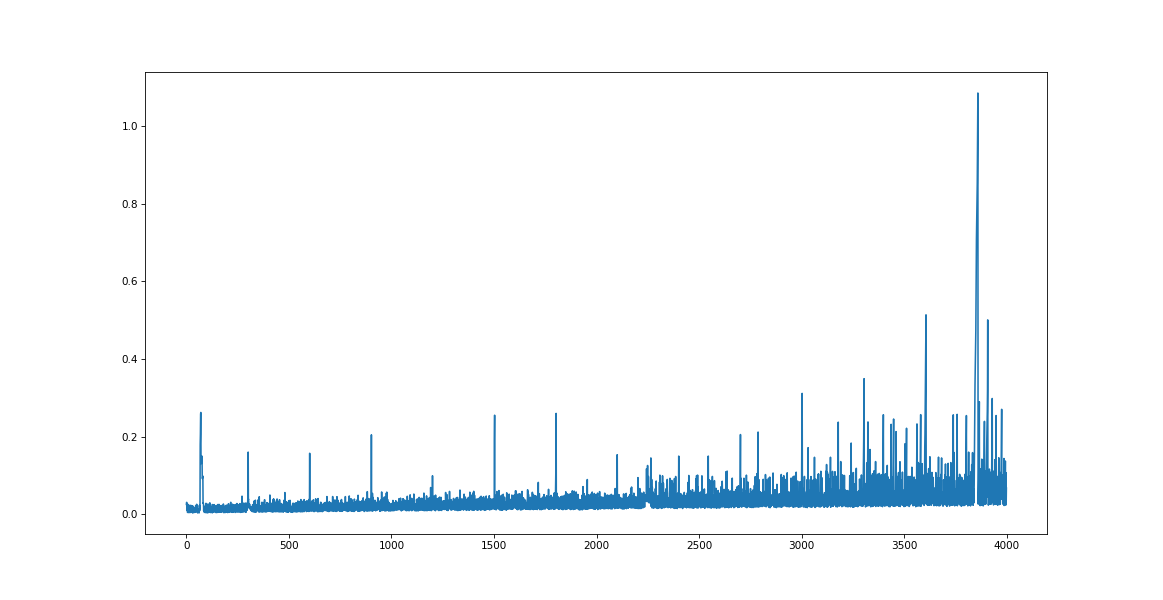

In [7]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt

def parse2pd(perf):
    caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
    long = max(len(caltime), len(colrtime), len(colgtime))
    if len(caltime) < long:
        perf["calcualte"] = caltime.extend([0]*(long - len(caltime)))
    if len(colrtime) < long:
        perf["col Radar"] = colrtime.extend([0]*(long - len(colrtime)))
    if len(colgtime) < long:
        perf["col GPS"] = colgtime.extend([0]*(long - len(colgtime)))
    pd_perf = pd.DataFrame(perf)
    return pd_perf
a = parse2pd(perf)
plt.figure(figsize=(8,8), dpi=60)
plt.plot(a['col Radar'])
plt.show()

整体趋势和第一次收集的数据差别不大。每300条数据后会出现一个峰值，大概是因为画图Bscan部分，每300道数据画一个图，我可以把画图（Bscan和波形图）这部分分割作为一个新的线程再看看时间消耗。   



In [35]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_5000_20Hz_splitBscan"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDraw = "draw"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[], perfDraw:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDraw].extend(perfTemp[perfDraw])

showPerf(perf)

Length caltime time, colrtime, colgtime:854 | 5000 | 4998
Max time: 
0.0028247319907848123|0.10455002010351677|0.0003463526803884065
Mean time: 
0.0004585239032770335|0.025404821891898754|3.218060331509122e-05


<IPython.core.display.Javascript object>


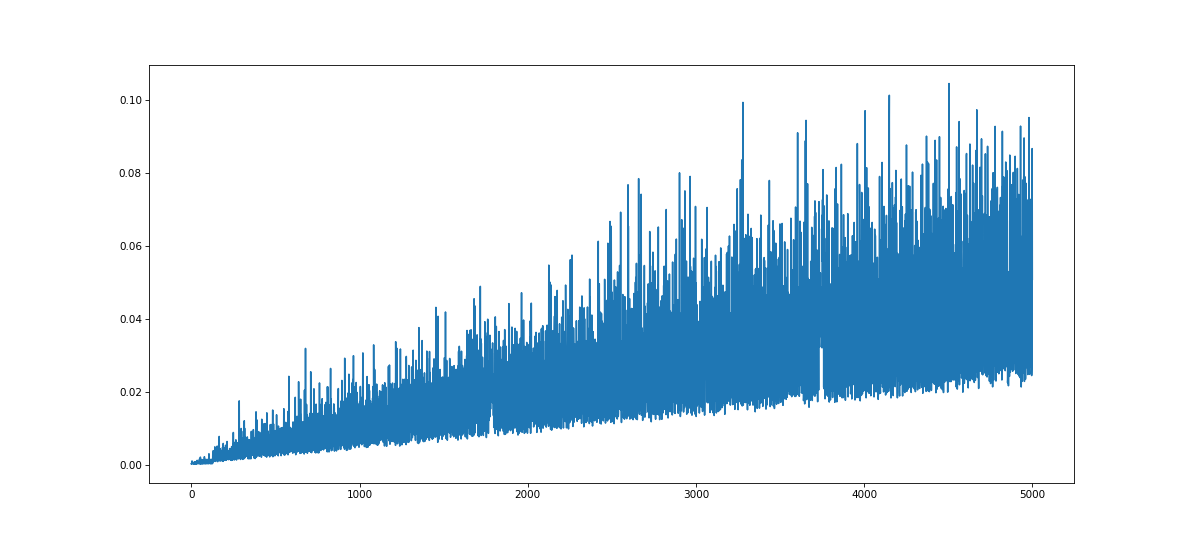

In [29]:
a = parse2pd(perf)
plt.figure(figsize=(8,8), dpi=60)
plt.plot(a['col Radar'])
plt.show()

啊这。。。
太不幸了，也并不是画图的问题，即使画图的线程分割了，到了5000条数据还是崩了。不过可以看到线程的消耗时间明显短了很多。。
那所以是为啥呢？
线程执行的频率越低，能收的数据越多，可是现在线程消耗时间短了这么多，为啥还是出问题？？难道是回收垃圾速度不行导致崩坏的吗？？超过我的认知了啊！！！
等等，是线程分配堆栈不够吗? 我试试把变量声明为全局变量看看。。

In [52]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_8000_20Hz_global"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDraw = "draw"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[], perfDraw:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDraw].extend(perfTemp[perfDraw])

showPerf(perf)

Length caltime time, colrtime, colgtime:1685 | 10000 | 9999
Max time: 
0.00035026797155524036|0.055992880193628025|0.00017468222142724699
Mean time: 
0.00018529381335496113|0.021991488096761793|9.212336415763317e-06


<IPython.core.display.Javascript object>


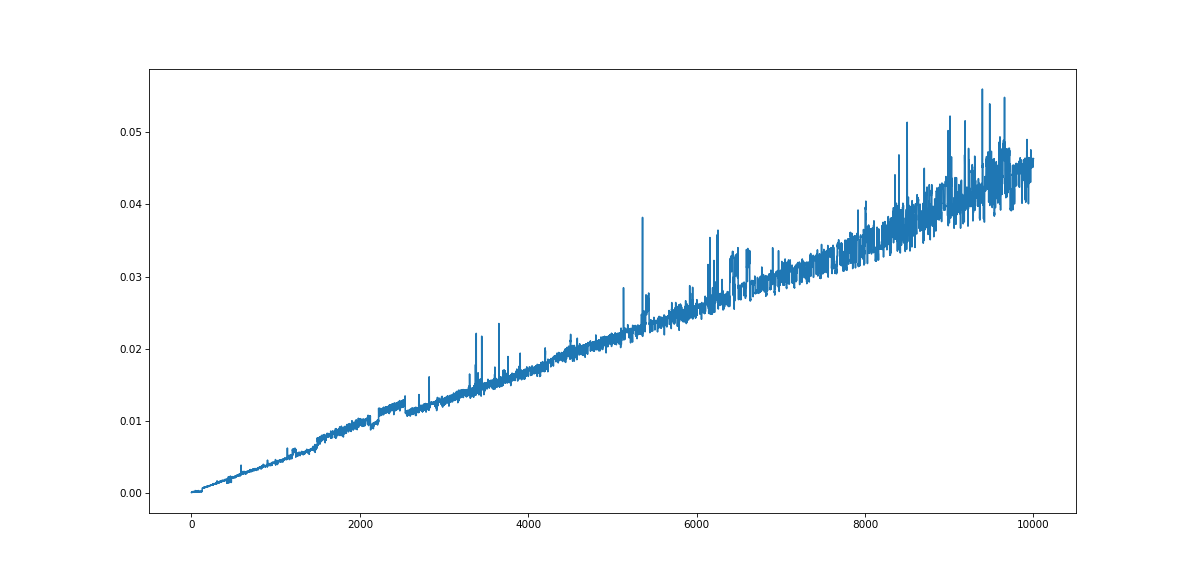

In [53]:
# a = parse2pd(perf)
plt.figure(figsize=(8,8), dpi=60)
plt.plot(perf["col Radar"])
plt.show()

haha， 我可能找到了原因！还是一样的频率，我只是把收集雷达数据方法的一个变量改为global，1W条了才卡死。 不过这时候刚好有一个同事的程序跑完，几乎100CPU占用率降下来，不知是否受了影响，我把频率调到0.08秒，比之前0.05秒慢一点，看看是否是因为后面变量太大，取数据时间太长导致的。

In [66]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_16000_12Hz"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDraw = "draw"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[], perfDraw:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDraw].extend(perfTemp[perfDraw])

showPerf(perf)

Length of col Radar is 16000
Max time conso for col Radar is 0.10254207808611682
Mean time conso for col Radar is 0.03516333211231427
Length of col GPS is 15999
Max time conso for col GPS is 0.00012559049366700492
Mean time conso for col GPS is 9.865060903790943e-06
Length of calcualte is 6406
Max time conso for calcualte is 0.0003849032395919494
Mean time conso for calcualte is 9.154826920799978e-05
Length of draw is 15986
Max time conso for draw is 2.049426033373493
Mean time conso for draw is 0.008768177125899362


<IPython.core.display.Javascript object>


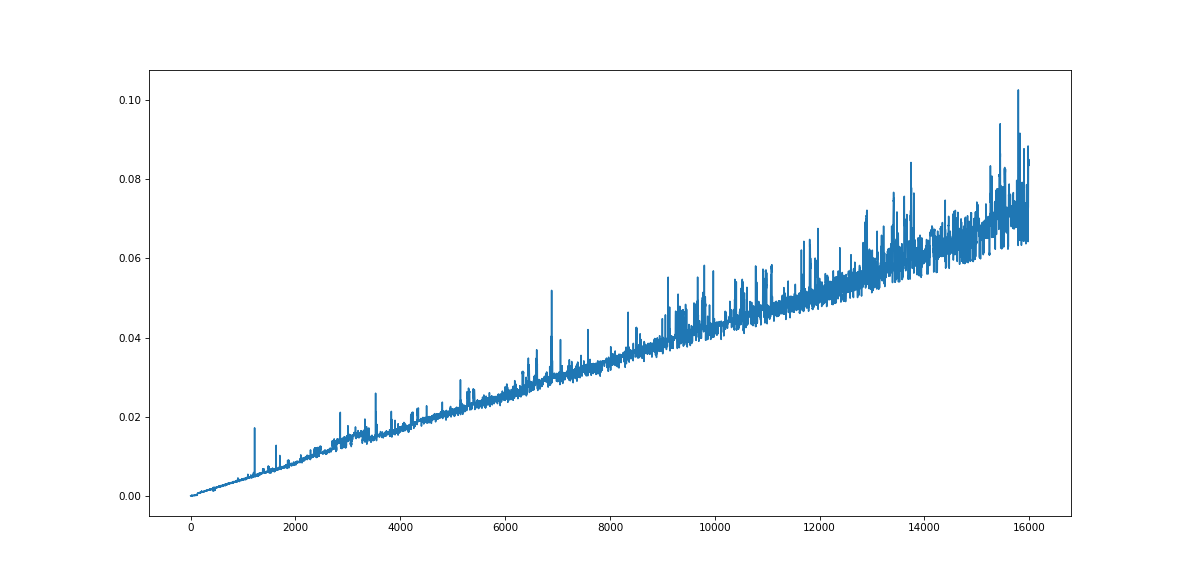

In [57]:
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(221)
plt.plot(perf["col Radar"])
# plt.subplot(222)
# plt.plot(perf["col GPS"])
plt.show()

好吧，那大概率是CPU占用导致之前只有5000数据就崩了。我把函数内变量都改为全局变量储存在堆里还是在1.1W这样爆了。   

所以究竟是什么问题呢？从前面两次数据上看，到了1W条之后，取数据的时间已经到了0.05秒一次， 到了1.8W条，这个时间增到了0.08秒，也恰好就在这个时间，程序卡死。待会再看看收数据这里到底费什么时间

等等 我发现了什么？？？狗头0v0
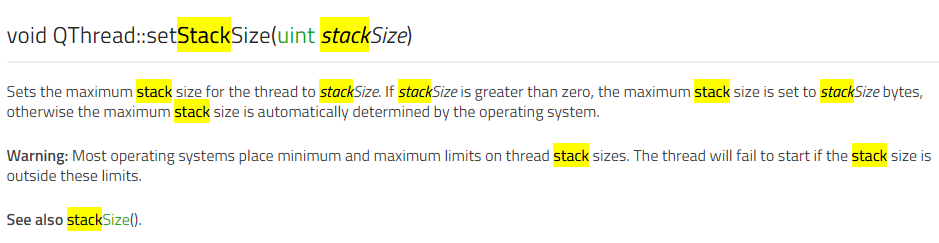

这意思就是说，stackSize是根据操作系统来的，那Windows操作系统默认栈才1M的大小。。我改成LINUX试试 。。
试了，并没有卵用。 看来还是时间的问题。

In [60]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_11_20Hz_colRadar"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perf = {perfTrans2NP:[], perfAppendNP:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])

showPerf(perf)

Length of trans is 11000
Max time conso for trans is 0.00027226332440477563
Mean time conso for trans is 9.680907876599644e-05
Length of append is 11000
Max time conso for append is 0.06435293036952316
Mean time conso for append is 0.024006623686991496


<IPython.core.display.Javascript object>


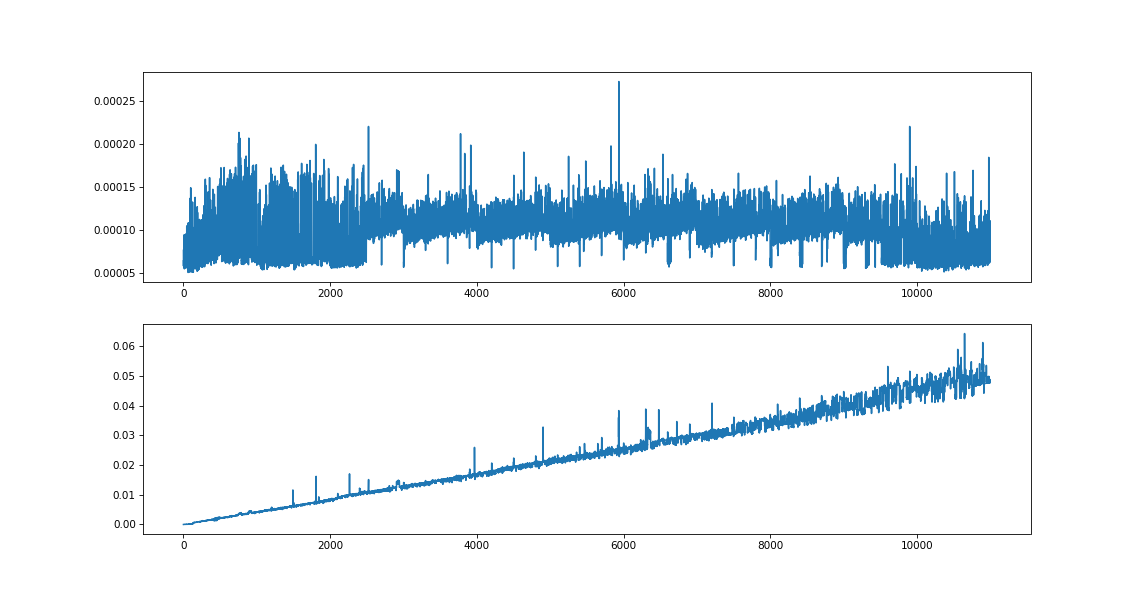

In [64]:
plt.figure(figsize=(8,8), dpi=60)
plt.subplot(211)
plt.plot(perf[perfTrans2NP])
plt.subplot(212)
plt.plot(perf[perfAppendNP])
plt.show()

结果一目了然了，很明显是因为numpy.append时间花销太长导致线程卡死，查了一下，原来numpy.append的方式是把原有数组重新复制一遍加入到新分配的内存里，我吐了，是我无知。
这样的话，有3种方式改良。
1. 继续用Append,但是把数据切片，为了保证速度在0.05以下甚至更快，大概每4000条就加入一个只用于最后保存的变量中，然后清空当前使用numpy数组，重新计算。 不过每5000条还是要append一次，有一定风险吧。。    

2. python自带的list带有动态扩充数组的功能，可以用list储存radar数据，在算法里再把需要的窗口截取出来转为NP，这就是一开始的做法，不过由于不知名的原因导致算法结果错误，或许可以再挑战一下。    
 
3. 可以先建好一个大小固定的NP数组，在数据来时候直接往里填，不过这样，算法会不知道当前数据收了多少，多加个参数

最后和小倪商量，选择了第二个方法。 为了不重蹈覆辙，来试试list性能，以及list转numpy的速度。

In [69]:
import time
a = []
start = time.clock()
for i in range(0, 70000):
    ele = [i for i in range(0, 1024)]
    a.append(ele)
print("生成7W * 1024 个点所需时间：" + str(time.clock() - start))

trans = []
for i in range(0, 300):
    start = time.clock()
    b = np.asarray(a[i:i+416]).T
    b = b[0:416,:]
    trans.append(time.clock() - start)
    if i % 30 == 0:
        print("第"+str(i)+"次转416*416numpy速度： " + str(trans[i]))

print("超大LIST转NP平均时间：" + str(np.mean(trans)))
append = []
for i in range(0, 100):
    start = time.clock()
    ele = [0] * 1024
    a.append(ele)
    append.append(time.clock() - start)
    if i % 10 == 0:
        print("第"+str(i)+"次在矩阵后追加长度的速度： " + str(append[i]))

print("超大LIST追加元素平均速度：" + str(np.mean(append)))
# 释放内存
a = []
trans = []
append = []

生成7W * 1024 个点所需时间：3.0320894252503194
第0次转416*416numpy速度： 0.018109125188402686
第30次转416*416numpy速度： 0.01762031614470061
第60次转416*416numpy速度： 0.01774560546212456
第90次转416*416numpy速度： 0.017597727926414564
第120次转416*416numpy速度： 0.01760345027506105
第150次转416*416numpy速度： 0.017643807891744245
第180次转416*416numpy速度： 0.017600739688845124
第210次转416*416numpy速度： 0.017642000834257487
第240次转416*416numpy速度： 0.017756447806902997
第270次转416*416numpy速度： 0.01764320553922971
超大LIST转NP平均时间：0.017777412685242477
第0次在矩阵后追加长度的速度： 5.722348646486353e-06
第10次在矩阵后追加长度的速度： 4.216467402784474e-06
第20次在矩阵后追加长度的速度： 4.216467402784474e-06
第30次在矩阵后追加长度的速度： 4.216467402784474e-06
第40次在矩阵后追加长度的速度： 4.216467402784474e-06
第50次在矩阵后追加长度的速度： 4.818819917318251e-06
第60次在矩阵后追加长度的速度： 4.216467431206183e-06
第70次在矩阵后追加长度的速度： 4.517643645840508e-06
第80次在矩阵后追加长度的速度： 4.517643674262217e-06
第90次在矩阵后追加长度的速度： 4.216467402784474e-06
超大LIST追加元素平均速度：6.086771887794384e-06


这个numpy速度咋这么慢的= =？？ 转换格式需要这么长时间，而且似乎和list大小毫无关系，我试过2W长度的list，时间也是0.017。 这就意味着计算的速度必须要慢下来了。。。不过其实也还好吧。

卧槽！！我他妈终于成功了！我去他妹的NUMPY!速度这么慢！！ NMSL！哇哈哈哈！来看看这第一次跑完的数据性能如何


In [74]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_25_20Hz_list"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
# perfColGPS = "col GPS"
perfCal = "calcualte"
perf = {perfTrans2NP:[], perfAppendNP:[],  perfColGPS:[], perfCal:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])

showPerf(perf)

Length of trans is 25000
Max time conso for trans is 0.00017257398769743304
Mean time conso for trans is 3.153957380533473e-05
Length of append is 25000
Max time conso for append is 0.00010360462795233616
Mean time conso for append is 1.6924418314941646e-06
Length of col GPS is 24999
Max time conso for col GPS is 7.258347477545612e-05
Mean time conso for col GPS is 8.084026262967164e-06
Length of calcualte is 12691
Max time conso for calcualte is 0.017194151759781562
Mean time conso for calcualte is 0.0037099217682867347


效果非常好！ 除了np.asarray转416x416矩阵以外都完美！

跑了一个比较完全的模拟数据，来看看时间消耗，也许可以加快速度。

In [8]:
import os, sys
path = "F:/RadarCAS/data/performance/perf_22_20Hz_cal1"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
# perfColGPS = "col GPS"
perfCal = "calcualte"
perf = {perfTrans2NP:[], perfAppendNP:[],  perfColGPS:[], perfCal:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])

showPerf(perf)

Length of trans is 22000
Max time conso for trans is 0.00017468222131356015
Mean time conso for trans is 3.3675542558577376e-05
Length of append is 22000
Max time conso for append is 8.222111455324921e-05
Mean time conso for append is 3.0127207266768996e-06
Length of col GPS is 21998
Max time conso for col GPS is 0.0001270963748822851
Mean time conso for col GPS is 1.0619686842476113e-05
Length of calcualte is 11168
Max time conso for calcualte is 1.9457677961277824
Mean time conso for calcualte is 0.016554575177381244


这里可以看到在prior步骤中雷达收集和GPS读取是非常快的，但是计算相对慢一些。最慢一次可以达到接近2S.
看看时间图。

<IPython.core.display.Javascript object>


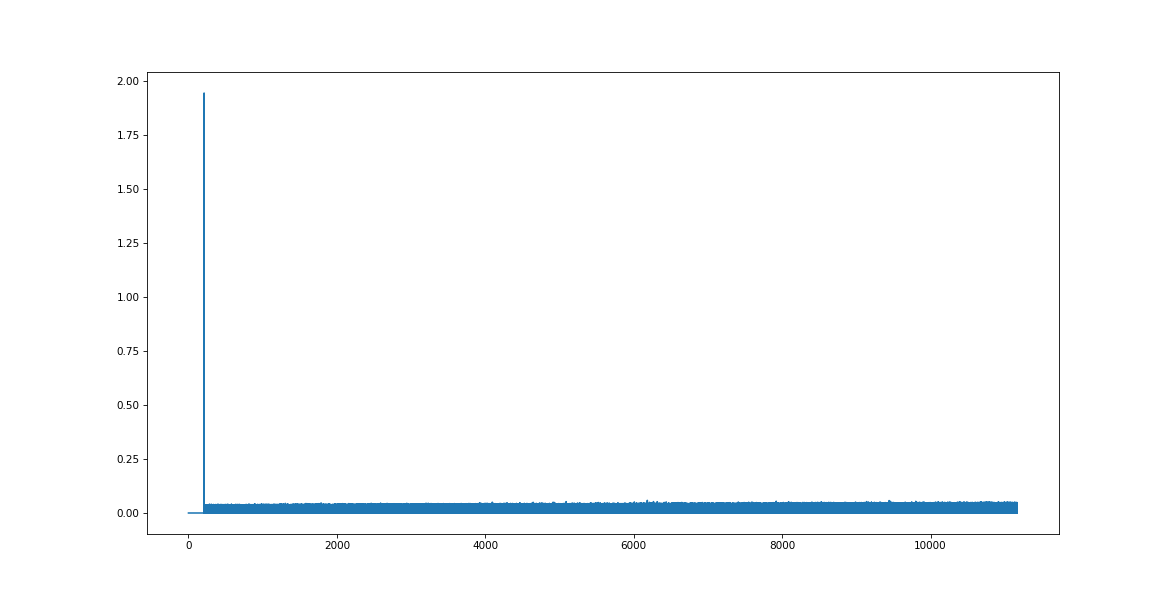

In [9]:
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(211)
plt.plot(perf[perfCal])
plt.show()

似乎只有第一次计算的时间特别长，如果不引起程序崩溃就还好（后来尝试了一下，0.01秒，不行，果然在第一次计算的时候引起崩溃了）。这是第一次的数据，看看第二次unregistered计算的。

In [11]:
path = "F:/RadarCAS/data/performance/perf_24_20Hz_cal2"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
# perfColGPS = "col GPS"
perfCal = "calcualte"
perf = {perfTrans2NP:[], perfAppendNP:[],  perfColGPS:[], perfCal:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])

showPerf(perf)

Length of trans is 23000
Max time conso for trans is 0.0001731763404677622
Mean time conso for trans is 3.0569703018539696e-05
Length of append is 23000
Max time conso for append is 0.00010571286156846327
Mean time conso for append is 2.849140360487344e-06
Length of col GPS is 209
Max time conso for col GPS is 7.37881798613671e-05
Mean time conso for col GPS is 1.0662215447555528e-05
Length of calcualte is 11652
Max time conso for calcualte is 3.758448520697584
Mean time conso for calcualte is 0.0015871294041250703


<IPython.core.display.Javascript object>


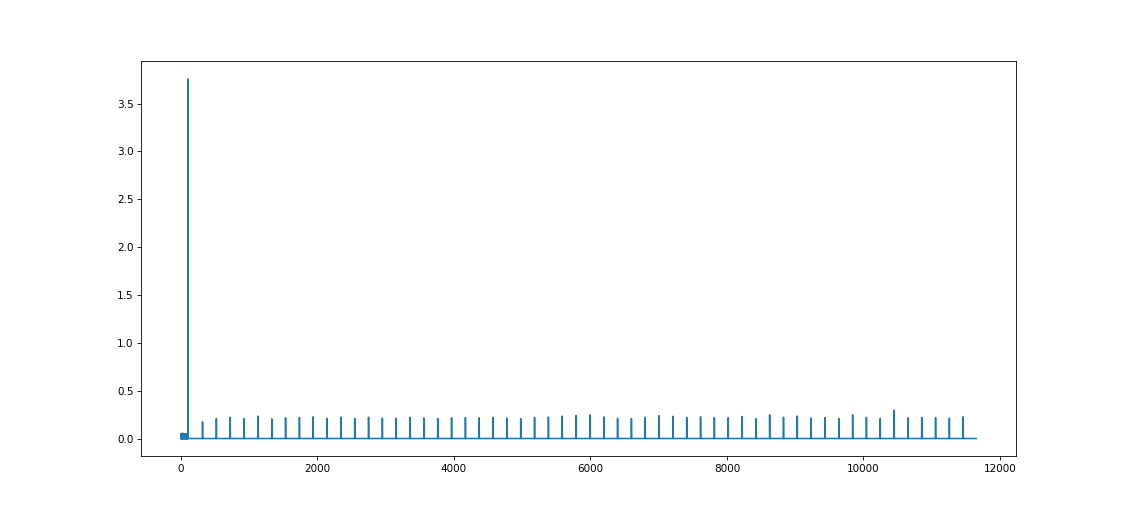

In [12]:
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(211)
plt.plot(perf[perfCal])
plt.show()

这其实有点尴尬，每次都是初始第一次计算会需要特别长的时间，也不是神经网络初始化的问题，而是计算feats时候的初始化，只能发生在线程开始以后，无法消除这个时间。是个隐患吧， 至少在使用0.05s的计算频率时会出问题。

In [21]:
import os
path = "E:/RadarCAS/data/performance/perf_3w_50Hz"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDraw = "draw"
perf = {perfTrans2NP:[], perfAppendNP:[],  perfColGPS:[], perfCal:[], perfDraw:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDraw].extend(perfTemp[perfDraw])

showPerf(perf)

Length of trans is 62000
Max time conso for trans is 0.00041140749249279907
Mean time conso for trans is 7.790236371224069e-05
Length of append is 31000
Max time conso for append is 0.00011535070984791673
Mean time conso for append is 2.5218601157011597e-06
Length of col GPS is 744
Max time conso for col GPS is 0.00081498438851213
Mean time conso for col GPS is 0.0005596836260239903
Length of calcualte is 7393
Max time conso for calcualte is 0.1302387819928299
Mean time conso for calcualte is 0.04627047166167167
Length of draw is 148
Max time conso for draw is 0.22331776952091786
Mean time conso for draw is 0.0968567843241989


In [22]:
%matplotlib notebook
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(211)
plt.plot(perf[perfCal])
plt.show()

TypeError: 'NoneType' object is not callable

<IPython.core.display.Javascript object>


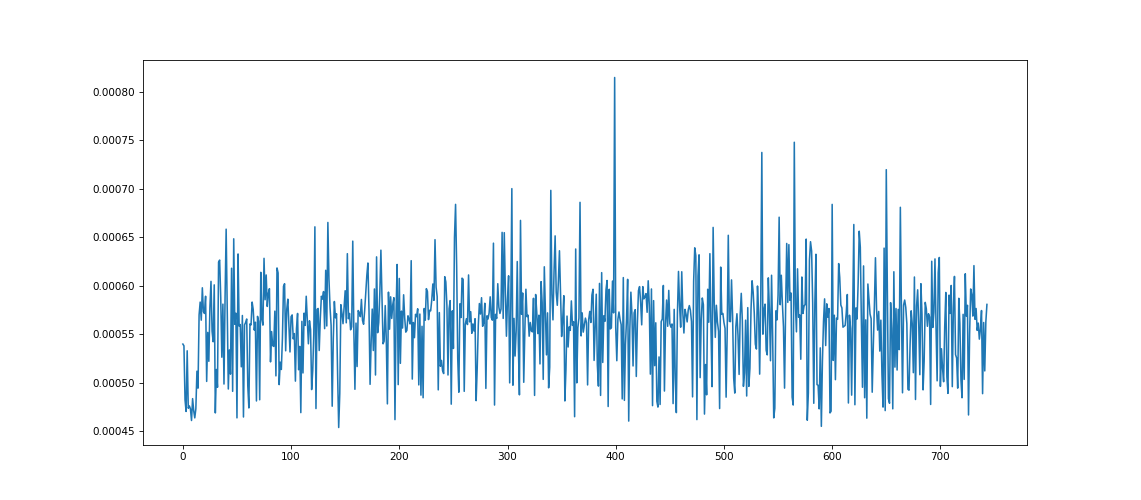

In [9]:
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(211)
plt.plot(perf[perfColGPS])
plt.show()

<IPython.core.display.Javascript object>


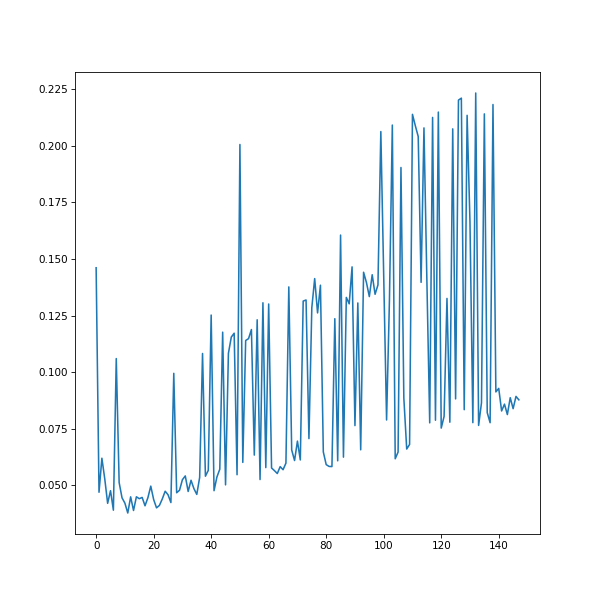

In [10]:
plt.figure(figsize=(8,8), dpi=60)
# plt.subplot(211)
plt.plot(perf[perfDraw])
plt.show()

注意这个图是画GPS的时间消耗，是随着点数增多而增加的， 此处为5S画一次， 在140个点时，平均时间已经翻了2倍。

In [54]:
import os
path = "E:/RadarCAS/data/performance/perf_slice_50Hz"
dirs = os.listdir( path )
perfTrans2NP = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDraw = "draw"
perf = {perfTrans2NP:[], perfAppendNP:[],  perfColGPS:[], perfCal:[], perfDraw:[]}
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDraw].extend(perfTemp[perfDraw])

showPerf(perf)

Length of trans is 18000
Max time conso for trans is 1.001026109316939
Mean time conso for trans is 0.000754733352963316
Length of append is 9000
Max time conso for append is 3.28282698944804e-05
Mean time conso for append is 3.4099905227533453e-06
Length of col GPS is 126
Max time conso for col GPS is 0.0009161797892858203
Mean time conso for col GPS is 0.0005225178243711702
Length of calcualte is 2172
Max time conso for calcualte is 5.362221106529546
Mean time conso for calcualte is 0.020055276207244014
Length of draw is 46
Max time conso for draw is 0.5027619417349314
Mean time conso for draw is 0.04356286535771959


perf_slice_50Hz 这里面存的都是程序出了些莫名其妙错误的数据，注意trans由于我代码写错了，把radar收和list.append的时间一起append到同一个地方，所以数据量翻倍了。。。 可以认为其中index%2=0的数据都是append的时间，index%2=1的数据是整个雷达收集完成的时间。
计算特征的时间最高一次达到了5S，且平均时间有0.02比之前都高，令人匪夷所思，之后似乎也没再出现过这样的情况。

<IPython.core.display.Javascript object>


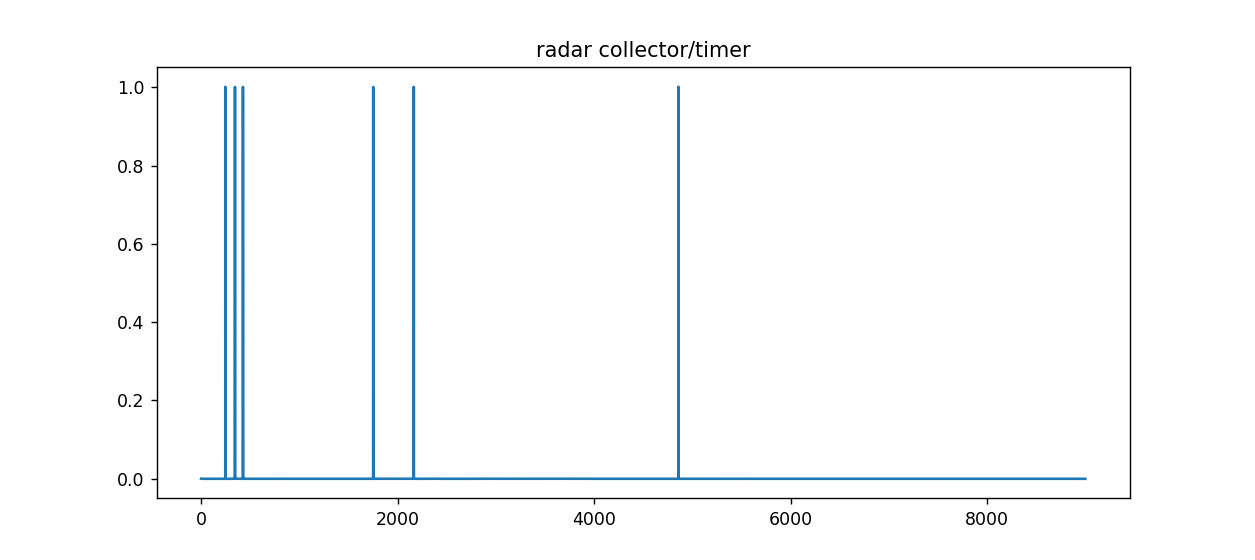

In [55]:
perf["trans"] = [perf[perfTrans2NP][i] for i in np.arange(0, len(perf[perfTrans2NP]),2)]
# perf["col radar"] = [perf[perfTrans2NP][i] for i in np.arange(1, len(perf[perfTrans2NP]),2)]
fig, ax = plt.subplots(1,1)
ax.plot(perf["trans"])
# ax.plot(perf["col radar"])
ax.set_title('radar collector/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


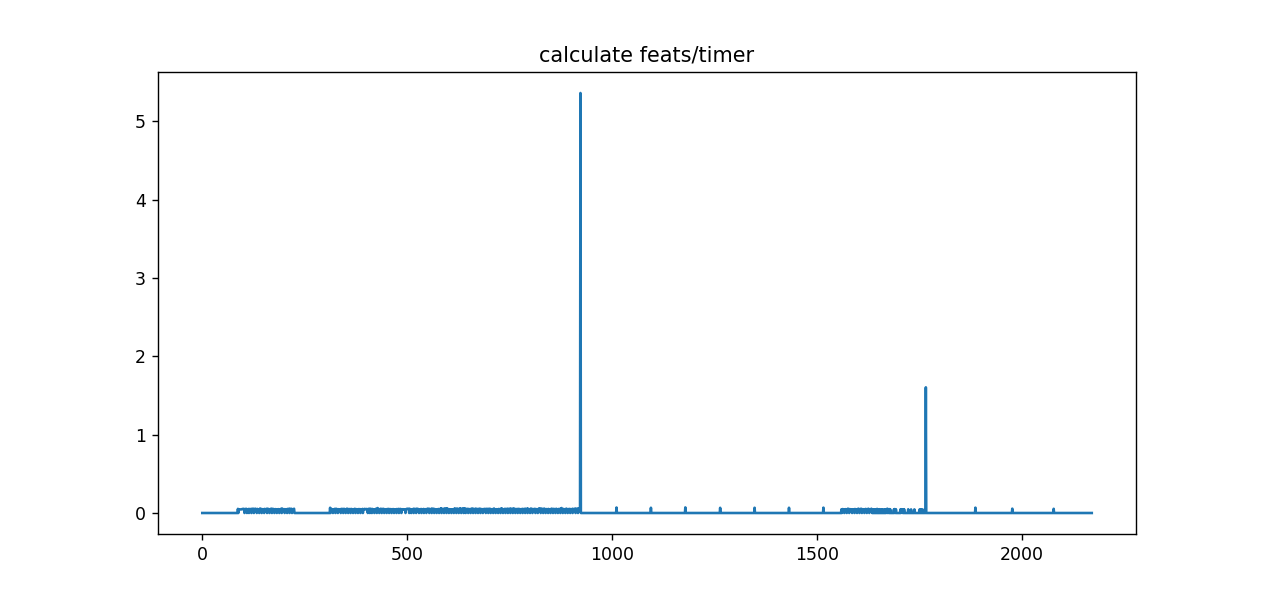

In [56]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('calculate feats/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


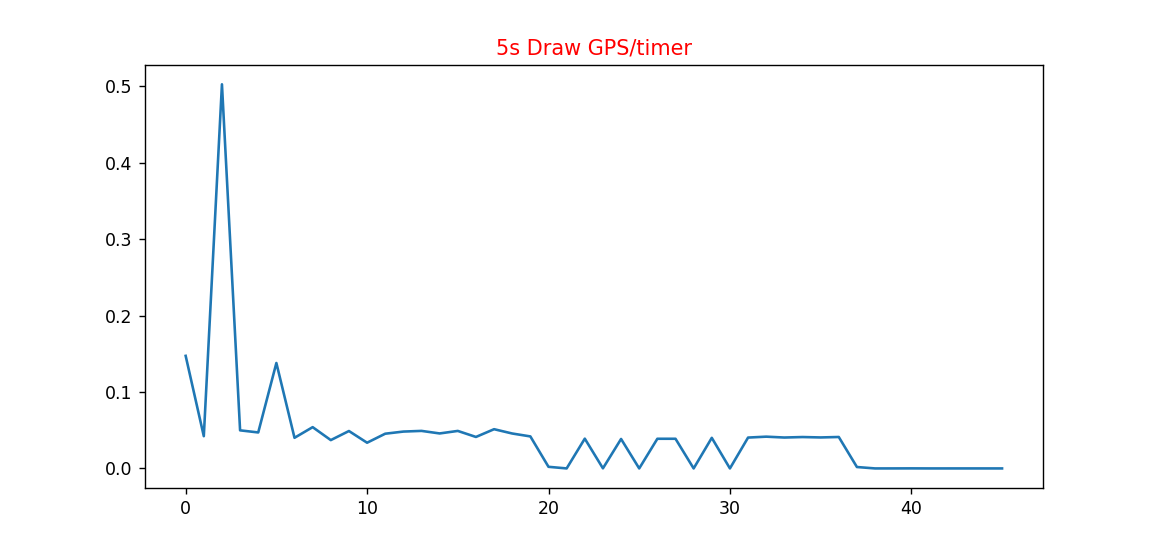

In [57]:
# plt.figure(figsize=(8,8), dpi=60)
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDraw])
ax.set_title('5s Draw GPS/timer',fontsize=12,color='r')
plt.show()

在最后一个模式真实GPS，真实雷达数据的测试中，有观察到3W数据时，程序运算接受等开始出现卡顿的情况，需要看两眼，果然到了3.7W数据，程序就崩溃了。
看看数据。

In [71]:
import os
path = "E:/RadarCAS/data/performance/perf_37_50Hz_full"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfColGPS:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
    perfTemp = loadFile(file)
    perf[perfTrans2NP].extend(perfTemp[perfTrans2NP])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])

showPerf(perf)

Length of trans is 36000
Max time conso for trans is 0.19965159869150284
Mean time conso for trans is 0.0001920473783883511
Length of append is 36000
Max time conso for append is 0.00016685194054844033
Mean time conso for append is 2.5258107671675133e-06
Length of col Radar is 36000
Max time conso for col Radar is 0.19965942928809
Mean time conso for col Radar is 0.00019707390185684184
Length of col GPS is 866
Max time conso for col GPS is 0.0009694880808410744
Mean time conso for col GPS is 0.0005345018540122096
Length of calcualte is 8602
Max time conso for calcualte is 0.12711919282207873
Mean time conso for calcualte is 0.047773384078695226
Length of drawGPS is 288
Max time conso for drawGPS is 0.4089968734838294
Mean time conso for drawGPS is 0.11774509352894776
Length of drawWave is 36005
Max time conso for drawWave is 1.3029031334131105
Mean time conso for drawWave is 0.007938508965130667


这是真实GPS和真实Radar接收的性能数据，看起来接收数据这一步不太对劲儿啊，怎么最多需要0.2秒， append依然让人安心，GPS似乎也不会有什么问题， 计算最长时间已经超过了0.1秒， 而画GPS图也堪忧。。。

<IPython.core.display.Javascript object>


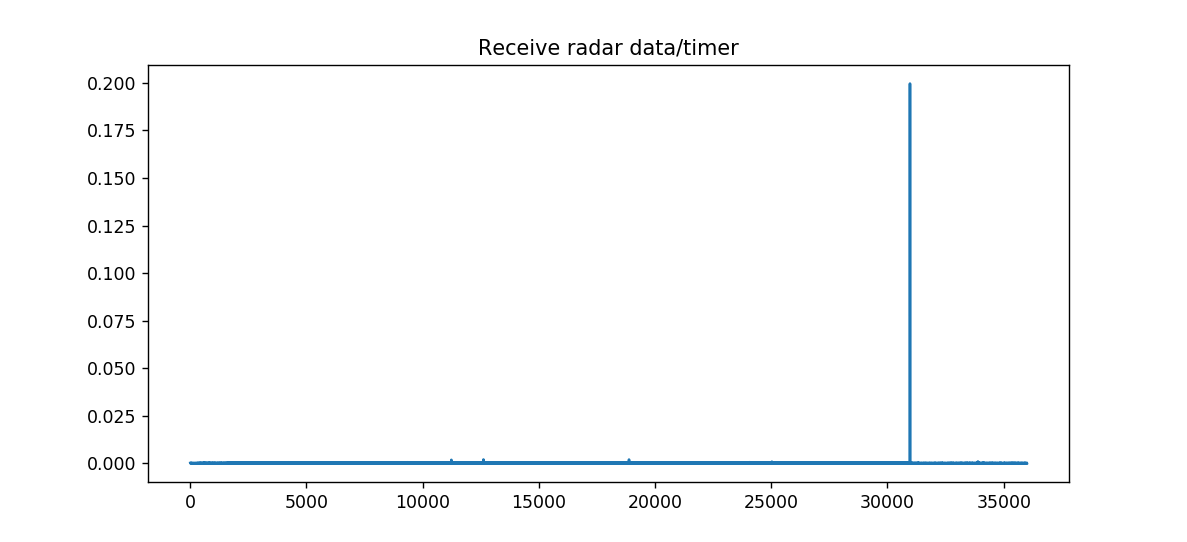

In [72]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfRecRadar])
ax.set_title('Receive radar data/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


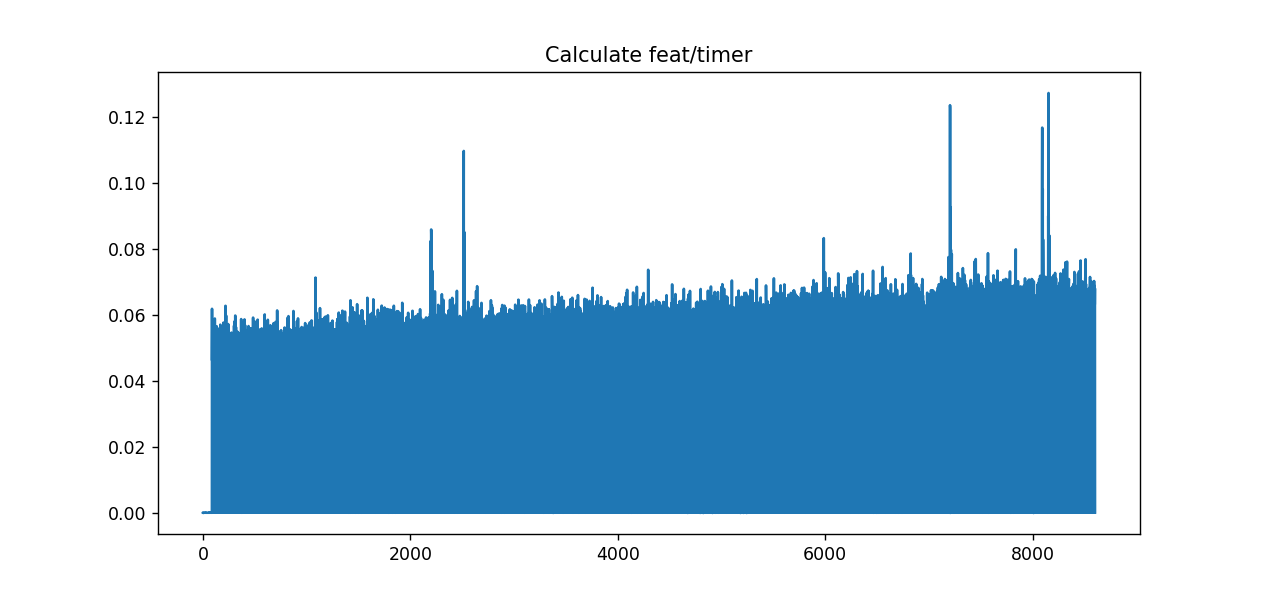

In [73]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('Calculate feat/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


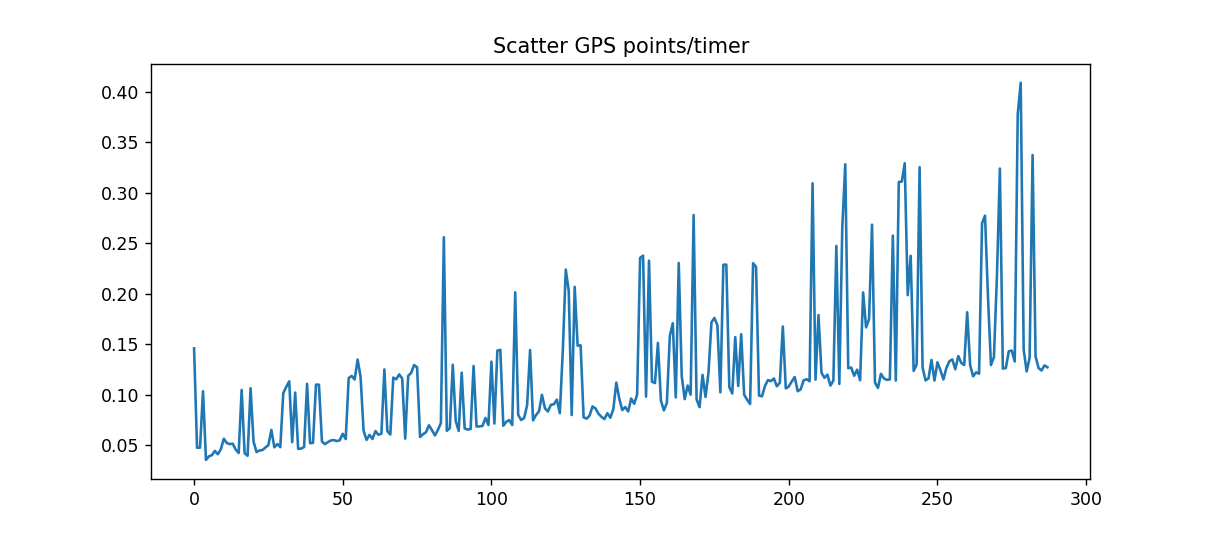

In [74]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawGPS])
ax.set_title('Scatter GPS points/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


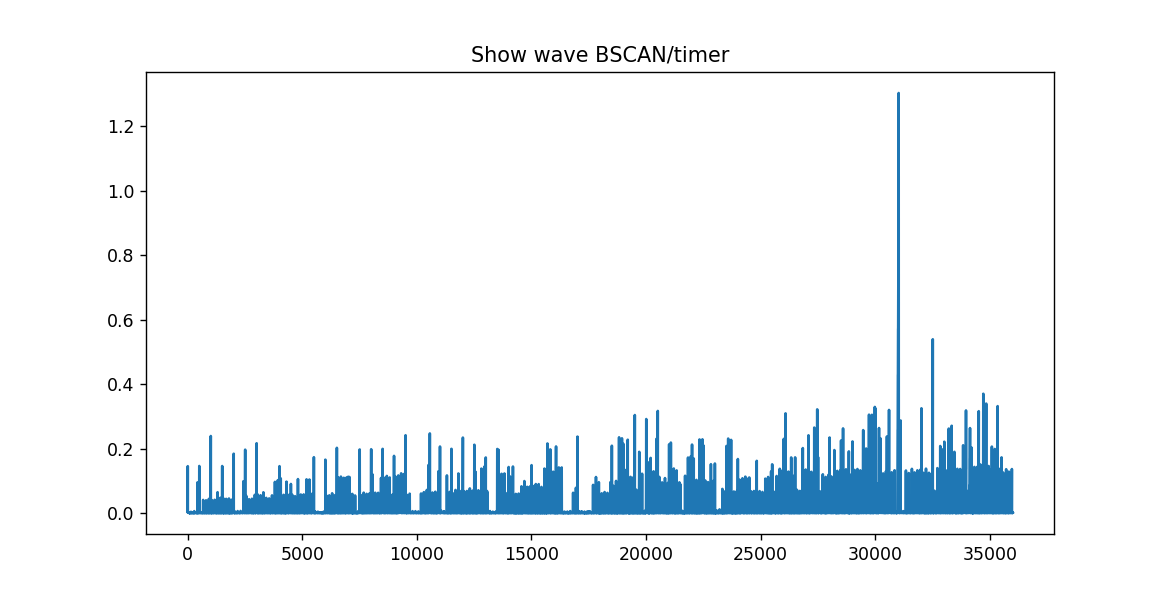

In [75]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawWave])
ax.set_title('Show wave BSCAN/timer',fontsize=12,color='black')
plt.show()

似乎数据所消耗时间的峰值都在3.1W，如果python中线程是以回溯的方式进行的，默认值为1000，还真有可能让程序崩溃的是这某个耗时特别长的点。。那怎么办呢。。 主要是搞不清楚是画BSCAN还是接收雷达数据慢了一点造成的这个峰值。。。

In [5]:
import os
path = "E:/RadarCAS/data/performance/perf_49_100Hz"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfColGPS:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfRecRadar].extend(perfTemp[perfRecRadar])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])

showPerf(perf)

Length of trans is 49000
Max time conso for trans is 0.010336688543134187
Mean time conso for trans is 0.00015327353261276544
Length of append is 49000
Max time conso for append is 0.0001782966585324175
Mean time conso for append is 2.1774098344724047e-06
Length of col Radar is 49000
Max time conso for col Radar is 0.010345422670013704
Mean time conso for col Radar is 0.0001574988769947414
Length of col GPS is 25673
Max time conso for col GPS is 0.00012830131174723647
Mean time conso for col GPS is 8.08775756768667e-06
Length of calcualte is 6358
Max time conso for calcualte is 0.10651448404348685
Mean time conso for calcualte is 0.05748015872307732
Length of drawGPS is 213
Max time conso for drawGPS is 0.7072793526144778
Mean time conso for drawGPS is 0.16922729646335924
Length of drawWave is 49723
Max time conso for drawWave is 0.7406181171692197
Mean time conso for drawWave is 0.013693808335257632


<IPython.core.display.Javascript object>


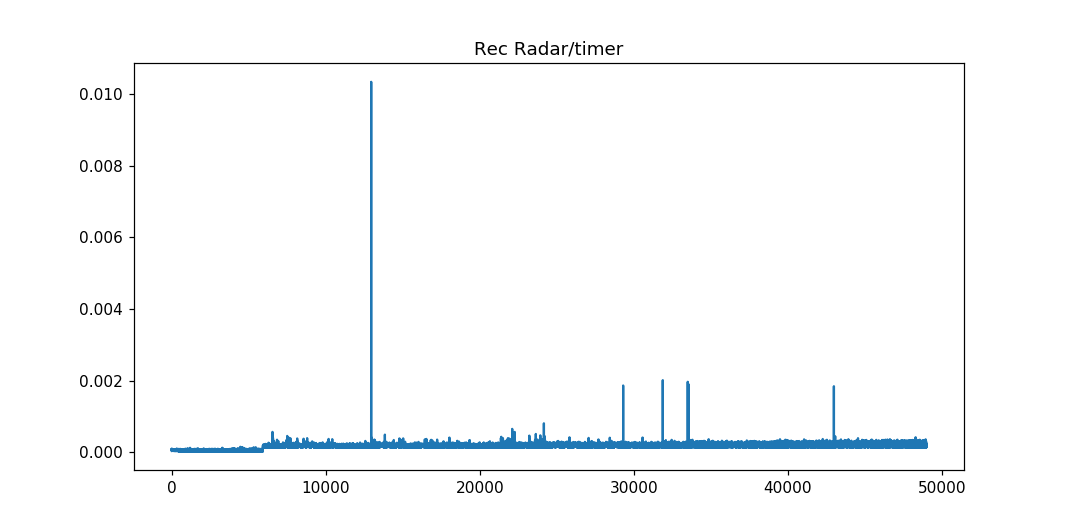

In [7]:
%matplotlib notebook
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfRecRadar])
ax.set_title('Rec Radar/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


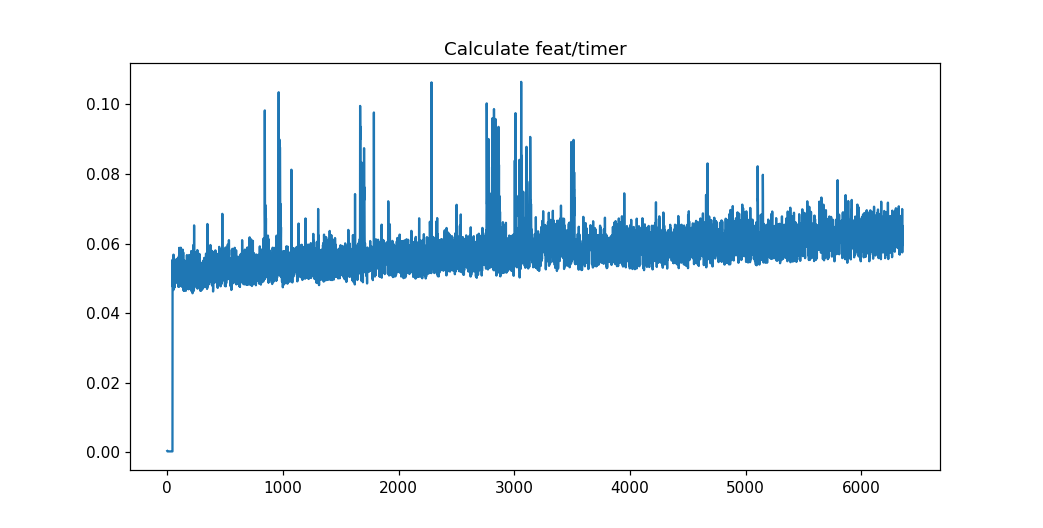

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('Calculate feat/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


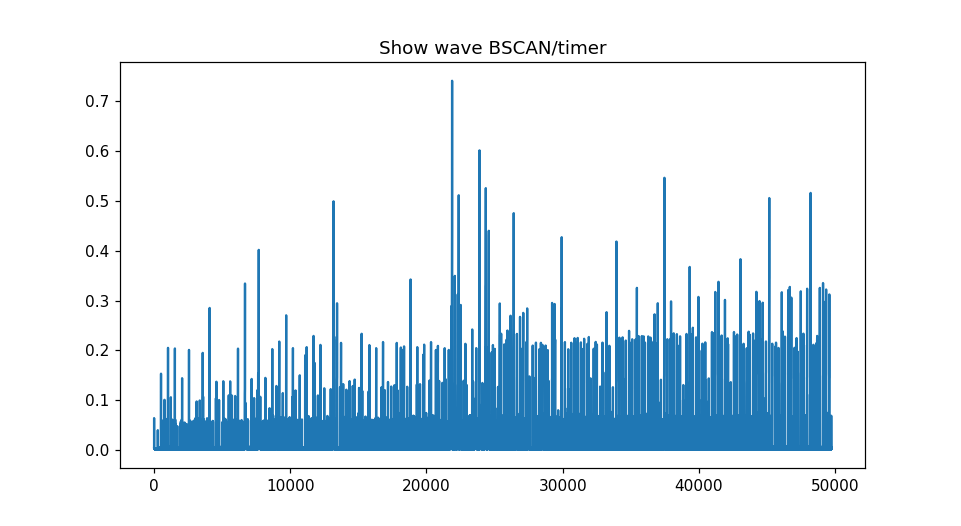

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawWave])
ax.set_title('Show wave BSCAN/timer',fontsize=12,color='black')
plt.show()

至此，性能的问题基本上解决了，速度的瓶颈就是计算Feats的速度，但是我没法解决。
我不敢把速度调整到0.1以下，有可能嗝屁。。
想要多一些Calculate的数据。。

In [12]:
import os
path = "E:/RadarCAS/data/performance/perf_54_100Hz_faster"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfColGPS:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfRecRadar].extend(perfTemp[perfRecRadar])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of trans is 52853
Max time conso for trans is 0.00029846619696627386
Mean time conso for trans is 4.582324511627654e-05
Length of append is 52853
Max time conso for append is 0.0005472382239304352
Mean time conso for append is 2.2463606913204398e-06
Length of col Radar is 52853
Max time conso for col Radar is 0.0006363865531966439
Mean time conso for col Radar is 5.020893371746289e-05
Length of col GPS is 1262
Max time conso for col GPS is 0.000865582088863448
Mean time conso for col GPS is 0.0004888843859487859
Length of calcualte is 10683
Max time conso for calcualte is 4.9499630907846495
Mean time conso for calcualte is 0.0628942293237249
Length of drawGPS is 230
Max time conso for drawGPS is 0.971045164772363
Mean time conso for drawGPS is 0.18233130528304503
Length of drawWave is 53244
Max time conso for drawWave is 1.7126174100061462
Mean time conso for drawWave is 0.01732346397371445


<IPython.core.display.Javascript object>


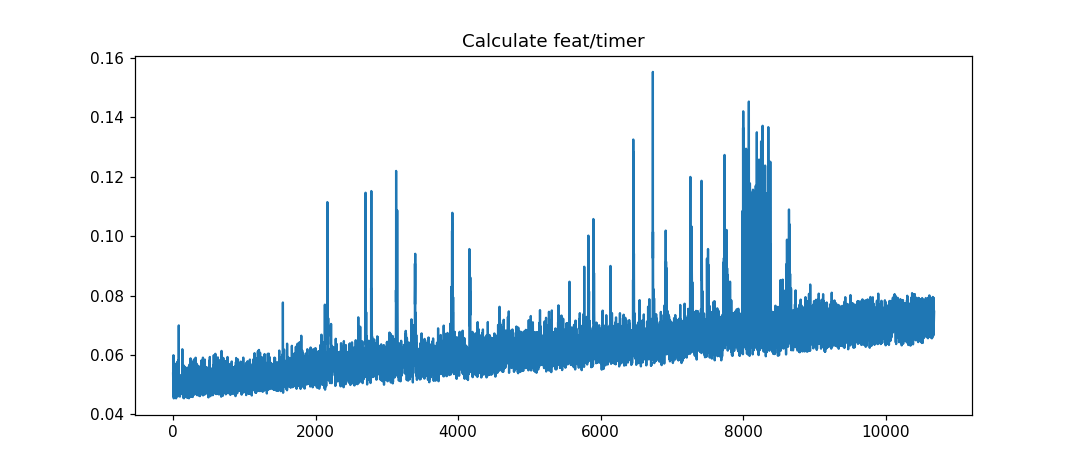

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal][0:-2])
ax.set_title('Calculate feat/timer',fontsize=12,color='black')
plt.show()

In [19]:
import os
path = "E:/RadarCAS/data/performance/per_51_100Hz_2"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfRecRadar].extend(perfTemp[perfRecRadar])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of trans is 51000
Max time conso for trans is 0.0007017419161456928
Mean time conso for trans is 0.00012771352092235086
Length of append is 51000
Max time conso for append is 0.00018642843178895419
Mean time conso for append is 2.350354127558746e-06
Length of col Radar is 51000
Max time conso for col Radar is 0.000760170212970479
Mean time conso for col Radar is 0.00013224129464650585
Length of calcualte is 5930
Max time conso for calcualte is 0.5282517380160243
Mean time conso for calcualte is 0.00892344932542279
Length of drawGPS is 199
Max time conso for drawGPS is 0.35054388010257753
Mean time conso for drawGPS is 0.09427021891077578
Length of drawWave is 53001
Max time conso for drawWave is 0.5822385808066883
Mean time conso for drawWave is 0.004976663679913701


<IPython.core.display.Javascript object>


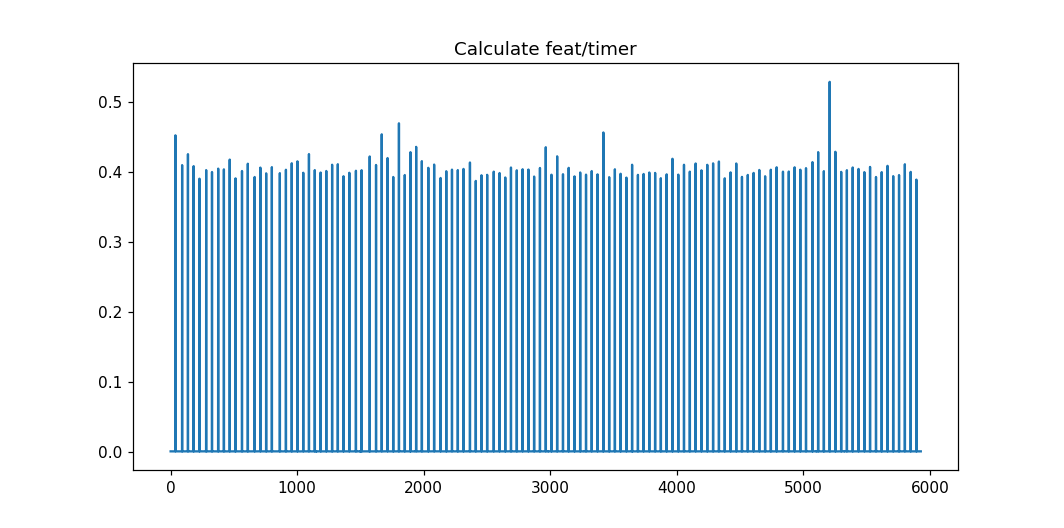

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal][0:-2])
ax.set_title('Calculate feat/timer',fontsize=12,color='black')
plt.show()

在收集多通道雷达的时候，到2W条以上就崩溃，大概是计算速度的问题， 看看。。

In [2]:
import os
path = "E:/RadarCAS/data/performance/perf_multiPipe_100Hz"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfRecRadar].extend(perfTemp[perfRecRadar])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of trans is 25000
Max time conso for trans is 0.025733147125777123
Mean time conso for trans is 8.388891515787919e-05
Length of append is 25000
Max time conso for append is 4.336945747240861e-05
Mean time conso for append is 2.308580315988138e-06
Length of col Radar is 25000
Max time conso for col Radar is 0.025740676545467522
Mean time conso for col Radar is 8.84310586753969e-05
Length of calcualte is 4355
Max time conso for calcualte is 0.2828694558247662
Mean time conso for calcualte is 0.05779228910167768
Length of drawGPS is 118
Max time conso for drawGPS is 1.14277556697283
Mean time conso for drawGPS is 0.21771891089715925
Length of drawWave is 25173
Max time conso for drawWave is 1.5511200915336758
Mean time conso for drawWave is 0.05044452550312654


<IPython.core.display.Javascript object>


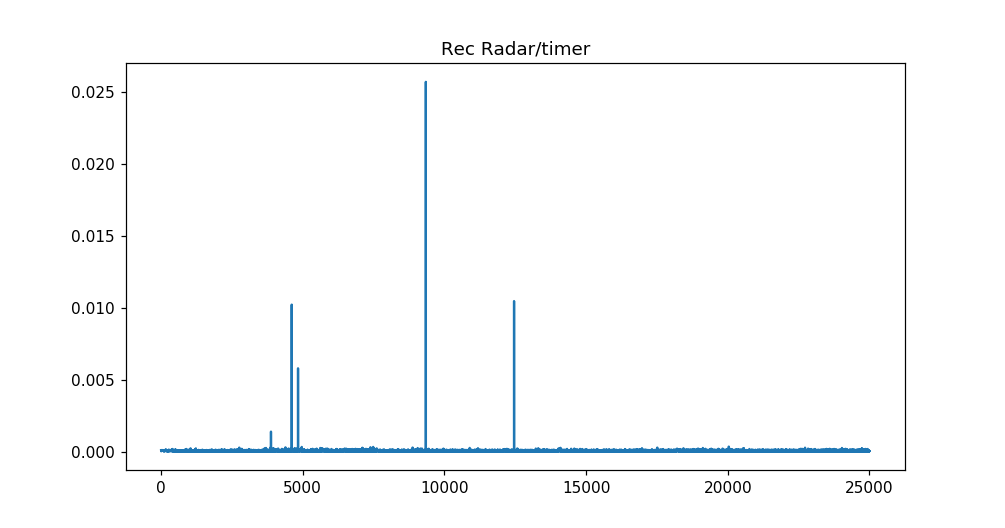

In [3]:
%matplotlib notebook
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfRecRadar])
ax.set_title('Rec Radar/timer',fontsize=12,color='black')
plt.show()

不是雷达收集引起的。。

<IPython.core.display.Javascript object>


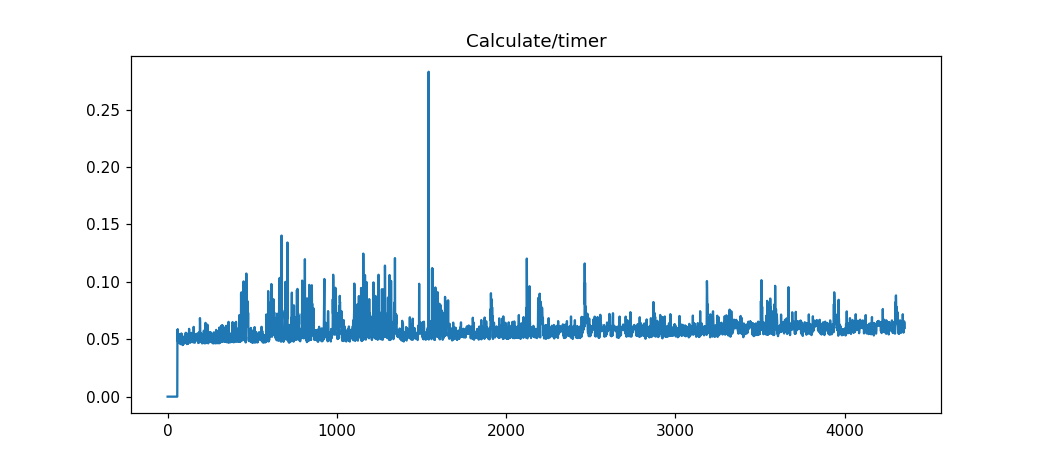

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('Calculate/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


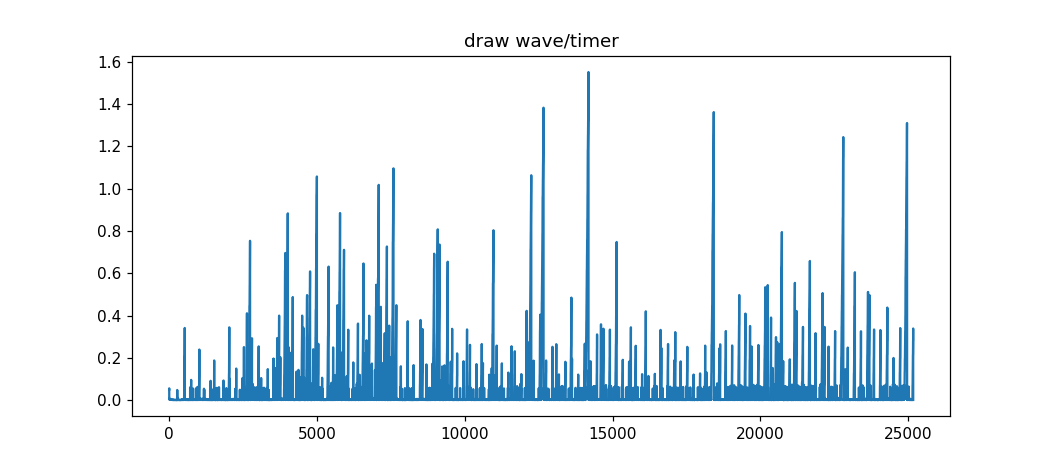

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawWave])
ax.set_title('draw wave/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


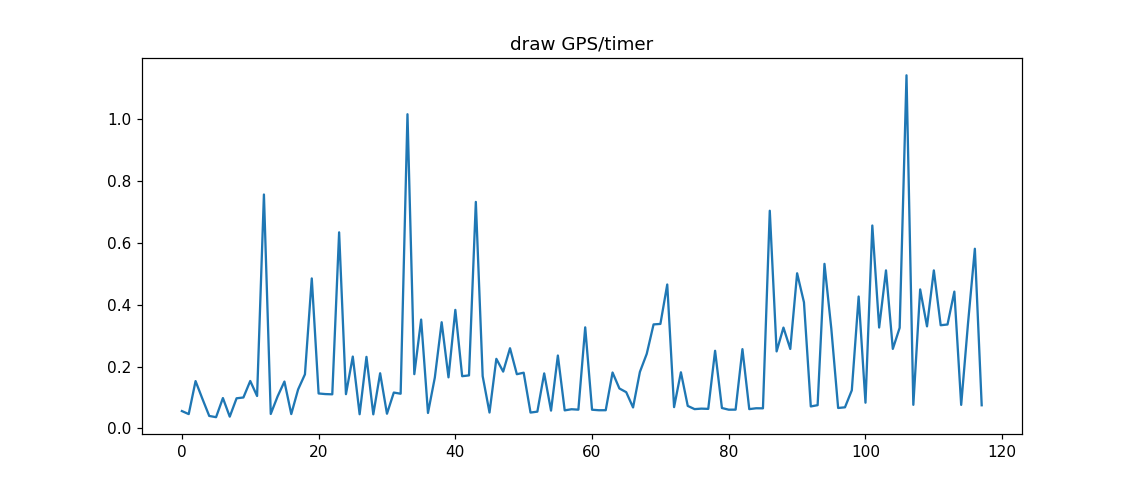

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawGPS])
ax.set_title('draw GPS/timer',fontsize=12,color='black')
plt.show()

从这些图中，引起崩溃的可能是计算，也可能是画波图。尚不确定， 我将计算过程中GPS转NP格式的步骤放到最后保存文件时执行看看是否好转。。    

现在收数据量到了3W多，还是崩溃了。。为啥呢，为啥用小雷达就没有这个问题，难道是我修改了计算时间？

In [8]:
import os
path = "E:/RadarCAS/data/performance/perf_multiP36_100Hz"
dirs = os.listdir( path )
perfRecRadar = "trans"
perfAppendNP = "append"
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calcualte"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfRecRadar:[], perfAppendNP:[], perfColRadar:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfRecRadar].extend(perfTemp[perfRecRadar])
    perf[perfAppendNP].extend(perfTemp[perfAppendNP])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of trans is 32000
Max time conso for trans is 0.0004285745694119214
Mean time conso for trans is 8.237829860112988e-05
Length of append is 32000
Max time conso for append is 0.0001972707961499509
Mean time conso for append is 2.247974134694797e-06
Length of col Radar is 32000
Max time conso for col Radar is 0.00043580281231925255
Mean time conso for col Radar is 8.685998803118844e-05
Length of calcualte is 5516
Max time conso for calcualte is 0.3016803556536445
Mean time conso for calcualte is 0.0561485608089944
Length of drawGPS is 148
Max time conso for drawGPS is 0.9686797222788073
Mean time conso for drawGPS is 0.22231609825829093
Length of drawWave is 32214
Max time conso for drawWave is 1.4192995290498516
Mean time conso for drawWave is 0.03008515914594427


<IPython.core.display.Javascript object>


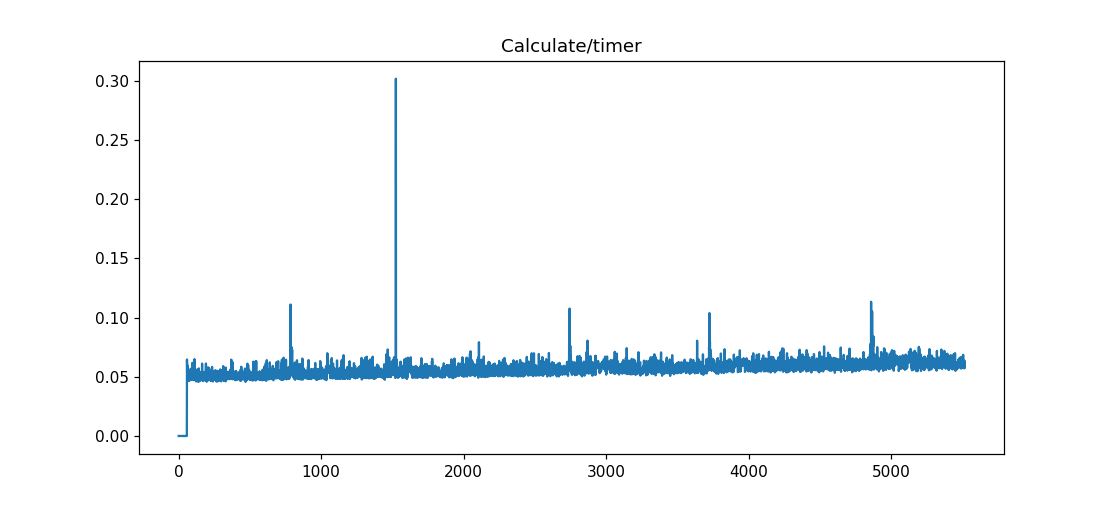

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('Calculate/timer',fontsize=12,color='black')
plt.show()

<IPython.core.display.Javascript object>


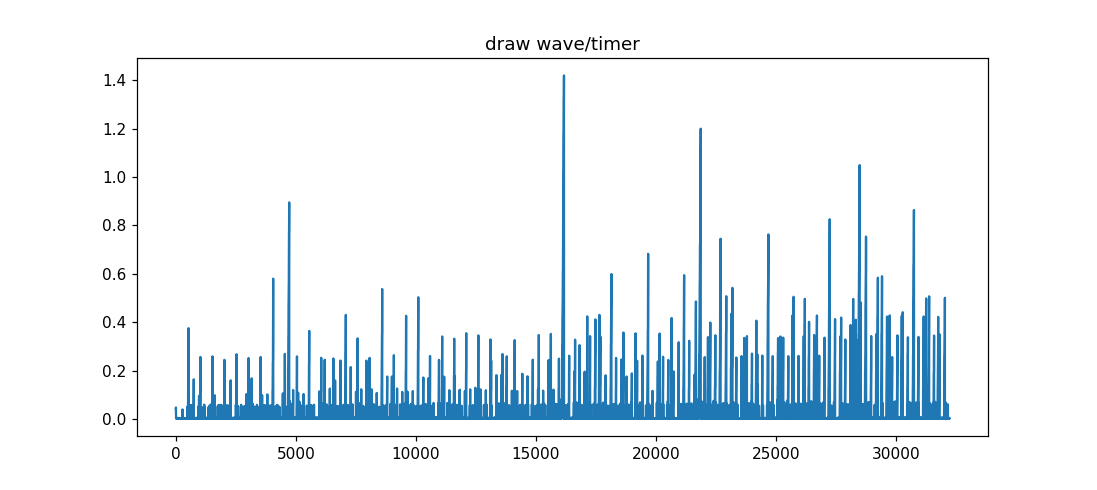

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfDrawWave])
ax.set_title('draw wave/timer',fontsize=12,color='black')
plt.show()

我发现Calculate的峰值都是每隔500个有一条特别久，且消耗时间是在缓慢增加的。。为啥呢。。       

嗯好像找到原因了，Feats也是用了np.append，太毒瘤了。。就是它！ 我把wave中bscan的画图时间调整大了也还是在3.6W炸掉。。      

我把np.append（feats)注释掉， 果然能吃5w以上的数据量。。

In [18]:
import os
path = "E:/RadarCAS/data/performance/perf_noAppend_100Hz"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calculate"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = { perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
#     perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of calculate is 8327
Max time conso for calculate is 0.12460496899529971
Mean time conso for calculate is 0.05036292037515706
Length of drawGPS is 224
Max time conso for drawGPS is 0.7800117398711848
Mean time conso for drawGPS is 0.19248345130356423
Length of drawWave is 48251
Max time conso for drawWave is 1.0651147227562205
Mean time conso for drawWave is 0.014667894948146768


In [21]:
import os
path = "E:/RadarCAS/data/performance/perf_5w_multi"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calculate"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of col Radar is 49000
Max time conso for col Radar is 0.0003135250363470732
Mean time conso for col Radar is 9.049414081760736e-05
Length of col GPS is 25594
Max time conso for col GPS is 0.00014095073680664427
Mean time conso for col GPS is 7.798483046896345e-06
Length of calculate is 8434
Max time conso for calculate is 0.13253103852683523
Mean time conso for calculate is 0.050753170823809486
Length of drawGPS is 227
Max time conso for drawGPS is 0.7552613326048885
Mean time conso for drawGPS is 0.19856545966637024
Length of drawWave is 49308
Max time conso for drawWave is 0.772761209875398
Mean time conso for drawWave is 0.015071655871837689


把feats.append机制改了以后明显好了不少。。跑完5W没问题     
换回小雷达，然后收了10W条数据

In [24]:
import os
path = "E:/RadarCAS/data/performance/perf_10W_100Hz"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calculate"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfColRadar:[], perfColGPS:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
    perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of col Radar is 126000
Max time conso for col Radar is 0.002875334795589879
Mean time conso for col Radar is 0.00014633385359956035
Length of col GPS is 1812
Max time conso for col GPS is 0.000917986850026864
Mean time conso for col GPS is 0.000507027133611364
Length of calculate is 21417
Max time conso for calculate is 0.08666211488070985
Mean time conso for calculate is 0.04886632516680368
Length of drawGPS is 575
Max time conso for drawGPS is 0.7655793481872024
Mean time conso for drawGPS is 0.2436193106018886
Length of drawWave is 126823
Max time conso for drawWave is 0.9764067139535655
Mean time conso for drawWave is 0.01975732604809819


<IPython.core.display.Javascript object>


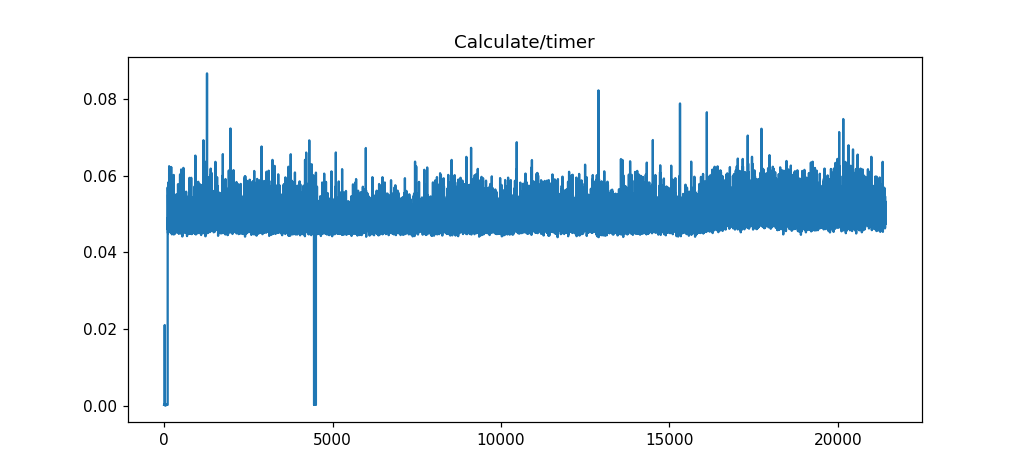

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(perf[perfCal])
ax.set_title('Calculate/timer',fontsize=12,color='black')
plt.show()

In [27]:
import os
path = "E:/RadarCAS/data/performance/perf_47_2"
dirs = os.listdir( path )
perfColRadar = "col Radar"
perfColGPS = "col GPS"
perfCal = "calculate"
perfDrawGPS = "drawGPS"
perfDrawWave = "drawWave"
perf = {perfColRadar:[], perfCal:[], perfDrawGPS:[], perfDrawWave:[]}
index = 0
for filename in dirs:
    file = path + '/' + filename
   
    perfTemp = loadFile(file)
#     print(perfTemp.keys())
#     perf[perfColGPS].extend(perfTemp[perfColGPS])
    perf[perfColRadar].extend(perfTemp[perfColRadar])
    perf[perfCal].extend(perfTemp[perfCal])
    perf[perfDrawWave].extend(perfTemp[perfDrawWave])
    perf[perfDrawGPS].extend(perfTemp[perfDrawGPS])
showPerf(perf)

Length of col Radar is 47000
Max time conso for col Radar is 0.0004291769232622755
Mean time conso for col Radar is 8.314851598307793e-05
Length of calculate is 6671
Max time conso for calculate is 10.647302404685888
Mean time conso for calculate is 0.016486035523840026
Length of drawGPS is 182
Max time conso for drawGPS is 0.3933959158621292
Mean time conso for drawGPS is 0.14179717431898473
Length of drawWave is 47464
Max time conso for drawWave is 1.1080589186126417
Mean time conso for drawWave is 0.016273800145348172
